# Importação e preparação dos dados

In [1]:
import pandas as pd

df = pd.read_csv('../dados/jurisprudencia_selecionada_excertos.CSV', sep = ';')
df.head()

,COD,NUM_ENUNCIADO,COD_AREA,DESCR_AREA,COD_TEMA,DESCR_TEMA,COD_SUBTEMA,DESCR_SUBTEMA,COD_DOC_TRAMITAVEL_EXCERTO,TEXTO_EXCERTO,ACORDAO,TIPO_PROCESSO
0,1400,1236,50,Responsabilidade,488,Solidariedade,261,Benefício previdenciário,54995438,Voto:Cuidam os autos de tomada de contas espec...,Acórdão 297/2016 - PL,Tomada de Contas Especial
1,1700,1534,46,Finanças Públicas,981,Exportação,983,Petróleo,55025603,Voto:Cuidam os autos de Solicitação do Congres...,Acórdão 366/2016 - PL,Solicitação do Congresso Nacional
2,5700,5314,50,Responsabilidade,203,Multa,1021,Dosimetria,55455375,Relatório:Trata-se de embargos de declaração o...,Acórdão 944/2016 - PL,Acompanhamento
3,284,40,45,Direito Processual,162,Princípio da independência das instâncias,481,Decisão judicial,54773747,Voto:8. Em relação a outros processos judiciai...,Acórdão 30/2016 - PL,Tomada de Contas Especial
4,298,54,49,Pessoal,141,Sistema S,142,Nepotismo,54773403,Voto:11. Relativamente ao ato envolvendo a Sra...,Acórdão 55/2016 - PL,Representação


In [2]:
df.shape

(13285, 12)

In [3]:
df.groupby(['DESCR_AREA']).size()

DESCR_AREA
Competência do TCU          553
Contrato Administrativo     941
Convênio                    683
Desestatização              139
Direito Processual         1811
Finanças Públicas           328
Gestão Administrativa       338
Licitação                  2756
Pessoal                    3393
Responsabilidade           2343
dtype: int64

In [4]:
areas = df.groupby(['DESCR_AREA']).groups.keys()
areas

dict_keys(['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização', 'Direito Processual', 'Finanças Públicas', 'Gestão Administrativa', 'Licitação', 'Pessoal', 'Responsabilidade'])

In [5]:
from sklearn.preprocessing import LabelBinarizer

lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
lbArea.classes_

array(['Competência do TCU', 'Contrato Administrativo', 'Convênio',
       'Desestatização', 'Direito Processual', 'Finanças Públicas',
       'Gestão Administrativa', 'Licitação', 'Pessoal',
       'Responsabilidade'], dtype='<U23')

In [6]:
y = lbArea.transform(df['DESCR_AREA'])
y.shape

(13285, 10)

In [7]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 20000
limite_texto = 2000
dim_vetor = 50

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['TEXTO_EXCERTO'])

sequences = tokenizer.texts_to_sequences(df['TEXTO_EXCERTO'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 63925 unique tokens.


In [8]:
max = 0
lens = []
for seq in sequences:
    lens.append(len(seq))
np.min(lens), np.mean(lens), np.max(lens), np.std(lens), len(lens), sum(pd.Series(lens) > 2000), sum(pd.Series(lens) > 2000)/len(lens)

(34,
 597.6371095220173,
 5231,
 499.176284044151,
 13285,
 286,
 0.02152803914188935)

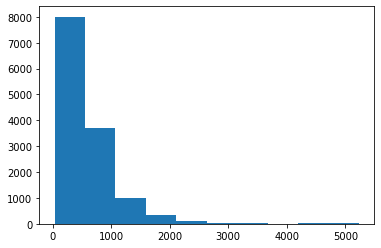

In [10]:
import matplotlib.pyplot as plt
plt.hist(lens)

plt.show()

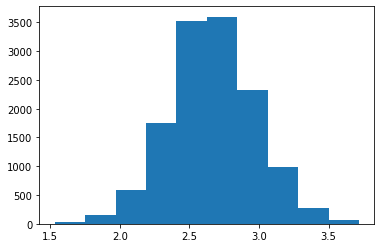

In [11]:
import matplotlib.pyplot as plt
plt.hist(np.log10(lens))
plt.show()

In [12]:
np.percentile(lens, 25), np.percentile(lens, 50), np.percentile(lens, 75), np.percentile(lens, 90), np.percentile(lens, 95)

(292.0, 456.0, 737.0, 1154.2000000000007, 1487.0)

In [13]:
np.mean(np.log10(lens)), 10**np.mean(np.log10(lens)), np.std(np.log10(lens)), (np.mean(np.log10(lens)) + 2*np.std(np.log10(lens))), 10**(np.mean(np.log10(lens)) + 2*np.std(np.log10(lens)))

(2.6653623489816365,
 462.7669650679938,
 0.30872107568640966,
 3.2828045003544557,
 1917.805237538811)

In [14]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (13285, 2000)


In [15]:
x.shape, y.shape

((13285, 2000), (13285, 10))

# Treinamento

In [16]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

#from keras.optimizers import RMSprop
#from keras.layers.core import Dense, Dropout, Activation

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W1101 23:52:00.159480 139854962562880 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1101 23:52:00.280405 139854962562880 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1101 23:52:00.282432 139854962562880 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1101 23:52:00.312664 139854962562880 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 50)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51200512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total para

In [17]:
history = model.fit(x, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W1101 23:52:05.006955 139854962562880 deprecation.py:323] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10628 samples, validate on 2657 samples
Epoch 1/50
10628/10628 [==============================] - 34s 3ms/step - loss: 1.8876 - categorical_accuracy: 0.3144 - val_loss: 1.6734 - val_categorical_accuracy: 0.4663
Epoch 2/50
10628/10628 [==============================] - 22s 2ms/step - loss: 0.9912 - categorical_accuracy: 0.6706 - val_loss: 1.1547 - val_categorical_accuracy: 0.6455
Epoch 3/50
10628/10628 [==============================] - 22s 2ms/step - loss: 0.4993 - categorical_accuracy: 0.8390 - val_loss: 1.1696 - val_categorical_accuracy: 0.6650
Epoch 4/50
10628/10628 [==============================] - 22s 2ms/step - loss: 0.2220 - categorical_accuracy: 0.9374 - val_loss: 1.3550 - val_categorical_accuracy: 0.6635
Epoch 5/50
10628/10628 [==============================] - 22s 2ms/step - loss: 0.1191 - categorical_accuracy: 0.9714 - val_loss: 1.6722 - val_categorical_accuracy: 0.6447
Epoch 6/50
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0787 - categori

10628/10628 [==============================] - 23s 2ms/step - loss: 0.0396 - categorical_accuracy: 0.9959 - val_loss: 2.3747 - val_categorical_accuracy: 0.6790
Epoch 49/50
10628/10628 [==============================] - 23s 2ms/step - loss: 0.0372 - categorical_accuracy: 0.9959 - val_loss: 2.3892 - val_categorical_accuracy: 0.6797
Epoch 50/50
10628/10628 [==============================] - 23s 2ms/step - loss: 0.0464 - categorical_accuracy: 0.9955 - val_loss: 2.2406 - val_categorical_accuracy: 0.6823


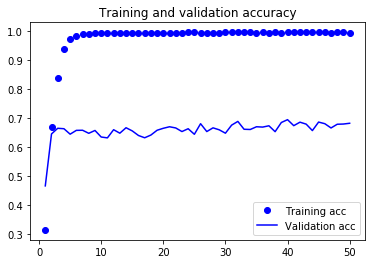

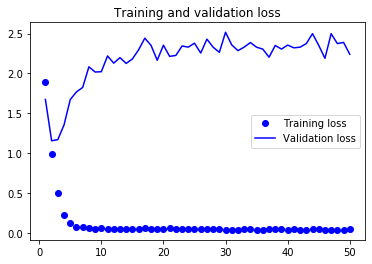

In [18]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10628 samples, validate on 2657 samples
Epoch 1/20
10628/10628 [==============================] - 24s 2ms/step - loss: 1.8929 - categorical_accuracy: 0.3152 - val_loss: 1.8616 - val_categorical_accuracy: 0.4035
Epoch 2/20
10628/10628 [==============================] - 23s 2ms/step - loss: 0.9628 - categorical_accuracy: 0.6828 - val_loss: 1.3781 - val_categorical_accuracy: 0.5634
Epoch 3/20
10628/10628 [==============================] - 23s 2ms/step - loss: 0.3286 - categorical_accuracy: 0.8988 - val_loss: 1.4618 - val_categorical_accuracy: 0.5977
Epoch 4/20
10628/10628 [==============================] - 23s 2ms/step - loss: 0.0915 - categorical_accuracy: 0.9797 - val_loss: 1.6273 - val_categorical_accuracy: 0.6402
Epoch 5/20
10628/10628 [==============================] - 23s 2ms/step - loss: 0.0505 - categorical_accuracy: 0.9924 - val_loss: 1.8185 - val_categorical_accuracy: 0.6364
Epoch 6/20
10628/10628 [==============================] - 23s 2ms/step - loss: 0.0438 - categori

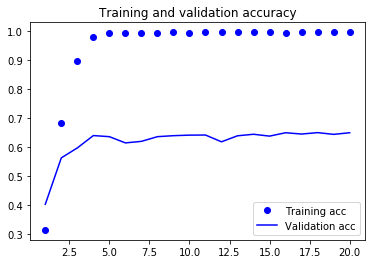

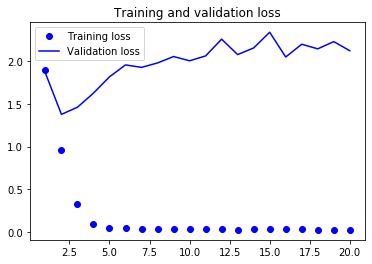

In [20]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()